In [1]:
%load_ext autoreload
%autoreload 2 

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb   
import matplotlib.pyplot as plt
import seaborn as sns


from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe

In [4]:
DATA_PATH = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'

In [6]:
processor_pipe = (ClassifierPipe(DATA_PATH)
             .read_raw_data(drop_na=True)
             .split_data(test_size=0.2,
                test_dev_size=0.5, 
                split_group = "mouse_id", 
                stratify_group = "sex", 
                target='signal',
                save_subject_ids=False,
                processed_data=False)
                # path_to_save =os.path.dirname(raw_path)
            .transform_data()
)

In [7]:
xgb_model=xgb.XGBRegressor(objective='reg:squarederror',
                       eval_metric='rmse')
xgb_model.fit(processor_pipe.X_train, processor_pipe.y_train)

/Users/mds8301/anaconda3/envs/enigma_xgb/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [8]:
xgb_model.score(processor_pipe.X_dev, processor_pipe.y_dev)

0.017760236078729563

In [34]:
def plot_dopamine_last_day_prediction(model):
    
    num_cols = processor_pipe.processor.named_transformers_["num"].get_feature_names_out().tolist()
    cat_cols = processor_pipe.processor.named_transformers_["cat"].get_feature_names_out().tolist()
    cols = num_cols + cat_cols

    predicted = model.predict(processor_pipe.X_test)
    testing_df = (pd.DataFrame(processor_pipe.X_test, columns=cols)
                .assign(predicted_signal = predicted,
                        true_signal = processor_pipe.y_test.reset_index(drop=True))
    )
    query = f"sensor_DA == 1 & event_cue == 1  & day=={testing_df.day.unique()[-1]}"
    test_query = testing_df.query(query)
    sns.lineplot(data=test_query, x="time", y="true_signal")
    sns.lineplot(data=test_query, x="time", y="predicted_signal")



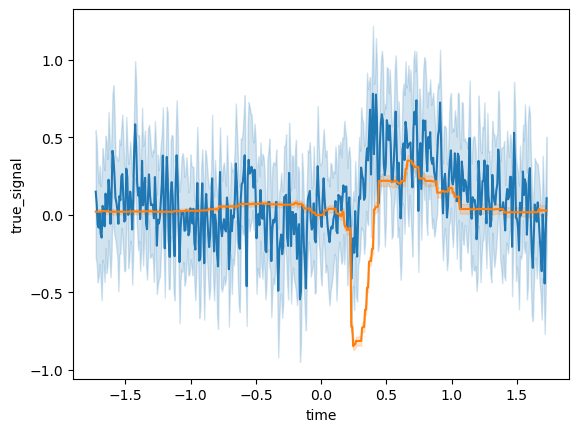

In [35]:
plot_dopamine_last_day_prediction(xgb_model)

In [42]:
xgb_model_tune = xgb.XGBRegressor(
                    objective='reg:squarederror',
                    eval_metric='rmse',
                    n_estimators=1000,
                    learning_rate = 0.001, 
                    max_depth = 1000,
                    max_leaves = 5,
                    gamma = 0.1,)
xgb_model_tune.fit(processor_pipe.X_train, processor_pipe.y_train)

/Users/mds8301/anaconda3/envs/enigma_xgb/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1000, max_leaves=5,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

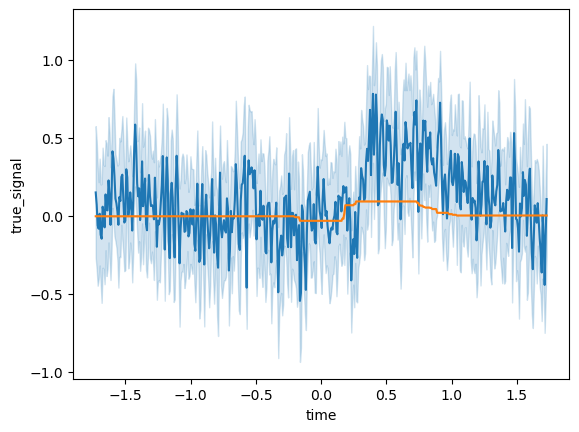

In [43]:
plot_dopamine_last_day_prediction(xgb_model_tune)